In [1]:
%run setup_Sv_compute.ipynb

# of files w/o bandwidth: 57
NB-VM-150         1088
OS-38              519
OS-75              363
WH-300             188
OS-150              26
NB-VM-300           25
NB-VM-75            14
BB-VM-150           13
OS-II-38             6
NB-DR-150            3
WH-Mariner-300       3
OS-II-75             1
DCP4400A             1
WH-Mariner-600       1
WH-1200              1
Name: instrument_name, dtype: int64


In [2]:
%run fxns_Sv_compute.ipynb

In [3]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from datetime import datetime
from datetime import time, timedelta
import itertools
from math import pi, cos, sin, acos
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import cm
from scipy.interpolate import interp1d
from shapely.geometry.polygon import LinearRing
import warnings

In [4]:
warnings.filterwarnings('ignore')

# Get Tropical Pacific cruises only + map them

In [5]:
lat_abs_lim = 20
lon_w_lim = 120 # 120E, had 100E before but got too many Ind Oc
lon_e_lim = 285 # 75W 
df['in_tp'] = "" # 0 = in tropical pac, 1 = not
df.reset_index(inplace=True, drop=True)
for ifile in np.arange(0,len(df)):
    fname = df['fname'][ifile]
    ncfile = dpath + 'JASADCP/ncfiles/' + fname
    nc = xr.open_dataset(ncfile)
    lon = nc['lon'].dropna(dim='time').values
    lat = nc['lat'].dropna(dim='time').values
    lon[lon<0] = lon[lon<0] + 360
    if (abs(lat) <= lat_abs_lim).any() and ((lon > lon_w_lim) & (lon < lon_e_lim)).any():
    # if any of the cruises profs are within the TP limits
        df.at[ifile,'in_tp'] = 1
    else:
        df.at[ifile,'in_tp'] = 0
dfnow = df[df['in_tp']==1]
# NOTE: skip ifile = 25 b/c that is weird DCP4400A instrument 
dfnow = dfnow[dfnow['instrument_name']!='DCP4400A']
# - Test
#pd.set_option('max_rows',10)
#dfnow['geo_region'].value_counts()
# --> dfnow looks good, but has a few Atl/Ind Oc files that are within the defined box
# - Old
#dfnow = df[df['geo_region'].notnull()]
#dfnow = dfnow[dfnow['geo_region'].str.contains('acific')]
dfnow.reset_index(inplace=True, drop=True)
fnamesnow = dfnow['fname'].values
print('# Tropical Pacific files:',len(fnamesnow))

# Tropical Pacific files: 547


# Prepare variables and params

In [23]:
pg_thresh = 0 # % good pings threshold (get rid of pts w/ pg<pg_thresh)
lat_nmost = 20 
lat_smost = -20 
lon_w_wmost = 100 # 100 = 100E
lon_w_emost = 190 # 190 = 150W 
lon_e_wmost = 220 # 220 = 140W
lon_e_emost = 285 # 190 = 75W 
std_depths = np.arange(0,1000+25,25)
timemin = dfnow['cruise_beg_date'].min()
timemax = dfnow['cruise_beg_date'].max()

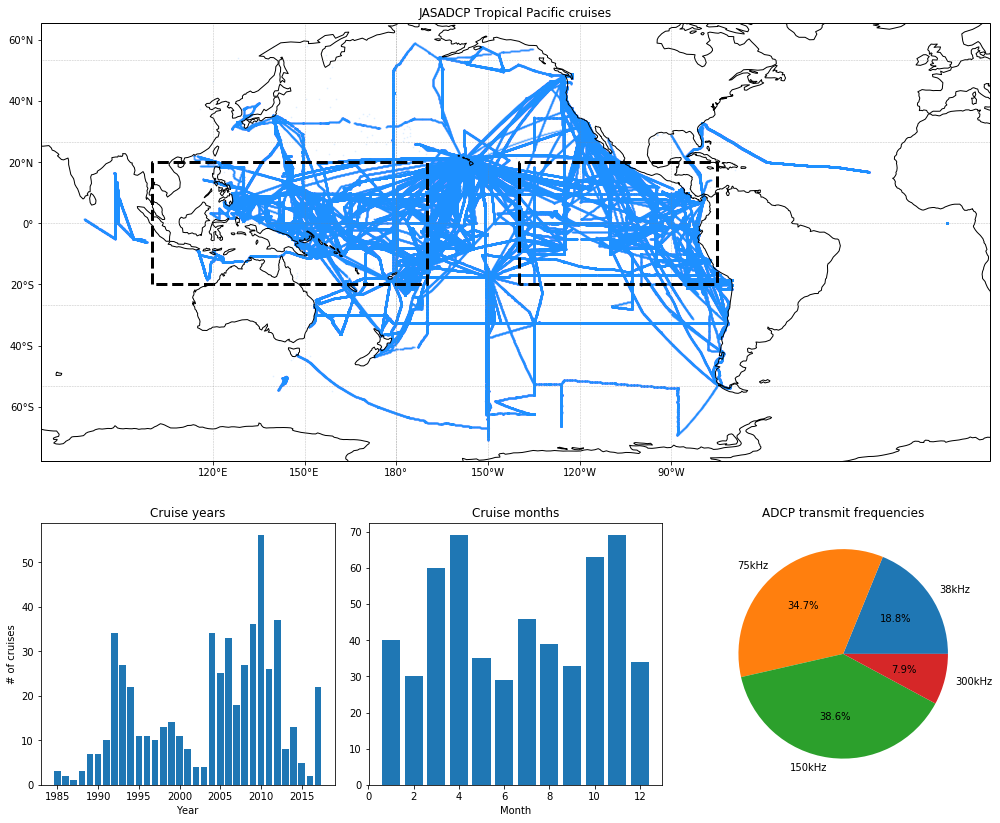

In [93]:
#%%script false --no-raise-error
fig = plt.figure(figsize=(14,12))
#ax0 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree(central_longitude=200))
ax0 = plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=2, projection=ccrs.PlateCarree(central_longitude=200))
ax = ax0; exec(open("create_map_bgs.py").read()) # make map pretty
#for fname in np.concatenate((fnamesnow[0:10],fnamesnow[1000:1100])):
for fname in fnamesnow:
    ncfile = dpath + 'JASADCP/ncfiles/' + fname
    nc = xr.open_dataset(ncfile)
    ax0.scatter(nc['lon'] ,nc['lat'], c='dodgerblue', s=0.5, alpha=0.1, transform=ccrs.PlateCarree());
ax0.set_xlabel(''); ax0.set_ylabel(''); ax0.set_title('JASADCP Tropical Pacific cruises')
wboxlons = [lon_w_wmost, lon_w_wmost, lon_w_emost, lon_w_emost]
wboxlats = [lat_smost, lat_nmost, lat_nmost, lat_smost]
wbox = LinearRing(list(zip(wboxlons, wboxlats)))
ax0.add_geometries([wbox], ccrs.PlateCarree(), facecolor='none', edgecolor='black',
                   linestyle='--', linewidth=3)
eboxlons = [lon_e_wmost-360, lon_e_wmost-360, lon_e_emost-360, lon_e_emost-360]
eboxlats = [lat_smost, lat_nmost, lat_nmost, lat_smost]
ebox = LinearRing(list(zip(eboxlons, eboxlats)))
ax0.add_geometries([ebox], ccrs.PlateCarree(), facecolor='none', edgecolor='black',
                   linestyle='--', linewidth=3)
#ax1 = plt.subplot(1, 3, 2)
ax1 = plt.subplot2grid((3,3), (2,0))
ax1.hist(dfnow['cruise_beg_date'].dt.year,
         bins=np.arange(dfnow['cruise_beg_date'].dt.year.min()-
                        0.5,dfnow['cruise_beg_date'].dt.year.max()+0.5), rwidth=0.8)
ax1.set_title('Cruise years')
ax1.set_xlabel('Year'); ax1.set_ylabel('# of cruises')
#ax2 = plt.subplot(1, 3, 3)
ax2 = plt.subplot2grid((3,3), (2,1))
ax2.hist(dfnow['cruise_beg_date'].dt.month, bins=np.arange(0.5,13), rwidth=0.8)
ax2.set_title('Cruise months')
ax2.set_xlabel('Month'); #ax2.set_ylabel('# of cruises')

ax3 = plt.subplot2grid((3,3), (2,2))
labels = '38kHz', '75kHz', '150kHz', '300kHz'
sizes = [len(dfnow[dfnow['freq_round_kHz']==38]), len(dfnow[dfnow['freq_round_kHz']==75]),
         len(dfnow[dfnow['freq_round_kHz']==150]), len(dfnow[dfnow['freq_round_kHz']==300])]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
ax3.pie(sizes, labels=labels, autopct='%1.1f%%')
ax3.set_title('ADCP transmit frequencies')
ax3.set_aspect('equal', 'box')
fig.tight_layout()
fig.savefig(figpath + 'JASADCP_Tropical_Pacific_cruises_info_poster1.png',
            bbox_inches='tight', pad_inches = 0, dpi = 200)

# Load/calc monthly ENSO time series

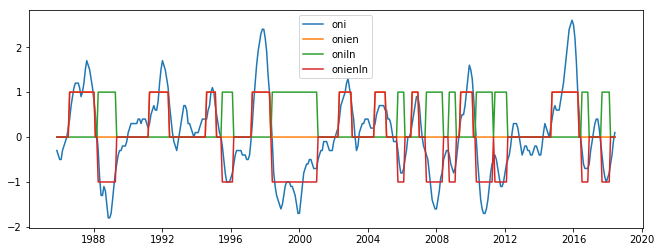

In [24]:
# - Load ONI 
dfoni = pd.read_csv(dpath+'oniindex1950_2018.txt',names=['Date','ONI']);
#dfoni.head(2)
# - Month fractions corresp to jan, feb, mar, etc. in the ONI txt file
monthfracs = [0,0.0834,0.1666,0.25,0.3334,0.4166,0.5,0.5834,0.6666,0.75,0.8334,0.9166];
# - Get ONI ts over desired timeframe
onibegmoidx = dfoni.index[dfoni['Date'] == (timemin.year + monthfracs[timemin.month-1])][0]
oniendmoidx = dfoni.index[dfoni['Date'] == (timemax.year + monthfracs[timemax.month-1])][0]
oni = dfoni['ONI'].iloc[onibegmoidx:(oniendmoidx+1)].values
onitime = pd.date_range(timemin.strftime('%Y-%m-01'), timemax.strftime('%Y-%m-01'), freq='MS') # should be 612 months long
# - Create EN/LN month classifications
onien = [0]*len(oni) # 1 = el nino month
oniln = [0]*len(oni) # 1 = la nina month
# - Classify El Nino months
cmcounter = 0; # consecutive months counter
for imonth in range(len(oni)):
    if oni[imonth]>=0.5:
        cmcounter=cmcounter+1;
    elif oni[imonth]<0.5:
        cmcounter=0;
    if cmcounter>=5:
        onien[imonth-cmcounter:imonth]=[1]*cmcounter;
# - Classify La Nina months
cmcounter = 0; # consecutive months counter
for imonth in range(len(oni)):
    if oni[imonth]<=-0.5:
        cmcounter=cmcounter+1;
    elif oni[imonth]>-0.5:
        cmcounter=0;
    if cmcounter>=5:
        oniln[imonth-cmcounter:imonth]=[1]*cmcounter;
# - Create everything to DataArrays
oni = xr.DataArray(oni, dims=('time'), coords={'time': onitime})
onien = xr.DataArray(onien, dims=('time'), coords={'time': onitime})
oniln = xr.DataArray(oniln, dims=('time'), coords={'time': onitime})
onienln = xr.zeros_like(onien, dtype='int')
onienln[onien==1] = 1 # el nino = 1
onienln[oniln==1] = -1 # la nina = -1
plotensoidx=1
if plotensoidx==1:
    fig = plt.figure(figsize=(11,4))
    plt.plot(onitime,oni)
    plt.plot(onitime,onien)
    plt.plot(onitime,oniln)
    plt.plot(onitime,onienln)
    plt.legend(["oni","onien","oniln","onienln"])

# Compile Sv cruise days

In [25]:
loadSvcd = 1

In [26]:
if loadSvcd==0:
    print(datetime.now().strftime("%H:%M:%S"))
    # Svcd = Sv cruise days
    #Svcd_en_w = np.full([24,len(std_depths)], np.nan)
    #Svcd_en_e = np.full([24,len(std_depths)], np.nan)
    #Svcd_ln_w = np.full([24,len(std_depths)], np.nan)
    #Svcd_ln_e = np.full([24,len(std_depths)], np.nan)
    #Svcd_na_w = np.full([24,len(std_depths)], np.nan)
    #Svcd_na_e = np.full([24,len(std_depths)], np.nan)
    #Svcd_all = [Svcd_en_w, Svcd_en_e, Svcd_ln_w, Svcd_ln_e, Svcd_na_w, Svcd_na_e]
    Svcd_all = [None,None,None,None,None,None]
    Svcd_icd = np.asarray([0,0,0,0,0,0])
    for ifile in np.arange(0,len(fnamesnow)):
    
        # - Calculate Sv + get rid of times w/o lon and lat
        fname = fnamesnow[ifile]
        print(ifile,fname)
        ncfile = dpath + 'JASADCP/ncfiles/' + fname
        nc = xr.open_dataset(ncfile)
        exec(open('calc_Sv.py').read()) # var calced = Sv
        
        # - Compute solar time
        solar_time = [None]*len(Sv['time'])
        for itime in range(0,len(Sv['time'])):
            lon = float(Sv_lon[itime])
            lat = float(Sv_lat[itime])
            utc_time = pd.to_datetime(Sv['time'].values[itime])
            solar_time[itime], _ = get_solar_time_and_angles(utc_time,lon,lat)
        Sv['time'] = solar_time; Sv_pflag['time'] = solar_time
        Sv_pg['time'] = solar_time; Sv_depth['time'] = solar_time
        Sv_lon['time'] = solar_time; Sv_lat['time'] = solar_time
        
        # - See how many days the cruise spans
        all_days = pd.to_datetime(Sv['time'].values).normalize().unique()
        print('# of days:',len(all_days))
        
        # - Append cruise day to appropriate matrix w/ standardized depths
        tot_cdays = len(all_days)
        daynow = pd.to_datetime(Sv['time'][0].values)
        for iday in range(0,tot_cdays):
            daynow = all_days[iday]
            daystrnow = daynow.strftime('%Y-%m-%d') 
            Svnow = Sv.where((Sv_pg>pg_thresh) & (Sv_pflag==0)).sel(time=daystrnow)
            Svhrnow = Svnow.groupby('time.hour').mean(dim='time') 
            Svdepthhrnow = Sv_depth.sel(time=daystrnow).groupby('time.hour').mean(dim='time')
            # - Standardize depths throughout
            Svhrnew = np.full([len(Svhrnow['hour']), len(std_depths)], np.nan)
            ihr = 0
            for hrnow in Svhrnow['hour']:
                old_depths = Svdepthhrnow.sel(hour=hrnow)
                old_Sv = Svhrnow.sel(hour=hrnow)
                good_idxs = np.where(~((std_depths>old_depths.max().values) | (std_depths<old_depths.min().values)))
                f = interp1d(old_depths, old_Sv)
                new_Sv = np.array([None]*len(std_depths))
                new_Sv[good_idxs] = f(std_depths[good_idxs])
                new_Sv = new_Sv.astype(float)
                Svhrnew[ihr,:] = new_Sv 
                ihr = ihr+1
            # - Append to appropriate matrix
            Svlonnow = Sv_lon.sel(time=daystrnow).mean()
            Svlatnow = Sv_lat.sel(time=daystrnow).mean()
            onitidxnow = (onienln['time'].dt.year==daynow.year) & (onienln['time'].dt.month==daynow.month)
            enlnnow = onienln[onitidxnow] # 1=EN, -1=LN, 0=nothing
            in_w = (Svlonnow>lon_w_wmost) & (Svlonnow<lon_w_emost) & (Svlatnow<lat_nmost) & (Svlatnow>lat_smost)
            in_e = (Svlonnow>lon_e_wmost) & (Svlonnow<lon_e_emost) & (Svlatnow<lat_nmost) & (Svlatnow>lat_smost)
            # Svcd_all order: Svcd_en_w, Svcd_en_e, Svcd_ln_w, Svcd_ln_e, Svcd_na_w, Svcd_na_e
            if in_w | in_e:
                if enlnnow==1: # EN
                    midx = 0 if in_w else 1
                elif enlnnow==-1: # LN
                    midx = 2 if in_w else 3
                elif enlnnow==0: # NA
                    midx = 4 if in_w else 5
                Svcdnow = np.full([24, len(std_depths)], np.nan)
                Svcdnow[Svhrnow['hour'].values, :] = Svhrnew
                if Svcd_icd[midx]==0:
                    Svcd_all[midx] = Svcdnow 
                else:
                    Svcd_all[midx] = np.dstack([Svcd_all[midx], Svcdnow])
                Svcd_icd[midx] += 1
    print(datetime.now().strftime("%H:%M:%S"))
    
    # - Clean up and package Svcd variables
    #Svcd_all = [Svcd_en_w, Svcd_en_e, Svcd_ln_w, Svcd_ln_e, Svcd_na_w, Svcd_na_e]
    midxnow = 0
    Svcd_enw_xr = xr.DataArray(Svcd_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
                 coords={'hour': np.arange(0,24),
                         'depth': std_depths,
                         'cruise_day': np.arange(0,Svcd_all[midxnow].shape[2])})
    Svcd_enw_xr.to_netcdf(dpath+'jasadcp_Sv_cruise_day_el_nino_WEP.nc')
    
    midxnow = 1
    Svcd_ene_xr = xr.DataArray(Svcd_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
                 coords={'hour': np.arange(0,24),
                         'depth': std_depths,
                         'cruise_day': np.arange(0,Svcd_all[midxnow].shape[2])})
    Svcd_ene_xr.to_netcdf(dpath+'jasadcp_Sv_cruise_day_el_nino_EEP.nc')
    
    midxnow = 2
    Svcd_lnw_xr = xr.DataArray(Svcd_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
                 coords={'hour': np.arange(0,24),
                         'depth': std_depths,
                         'cruise_day': np.arange(0,Svcd_all[midxnow].shape[2])})
    Svcd_lnw_xr.to_netcdf(dpath+'jasadcp_Sv_cruise_day_la_nina_WEP.nc')
    
    midxnow = 3
    Svcd_lne_xr = xr.DataArray(Svcd_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
                 coords={'hour': np.arange(0,24),
                         'depth': std_depths,
                         'cruise_day': np.arange(0,Svcd_all[midxnow].shape[2])})
    Svcd_lne_xr.to_netcdf(dpath+'jasadcp_Sv_cruise_day_la_nina_EEP.nc')
    
    midxnow = 4
    Svcd_naw_xr = xr.DataArray(Svcd_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
                 coords={'hour': np.arange(0,24),
                         'depth': std_depths,
                         'cruise_day': np.arange(0,Svcd_all[midxnow].shape[2])})
    Svcd_naw_xr.to_netcdf(dpath+'jasadcp_Sv_cruise_day_la_nada_WEP.nc')
    
    midxnow = 5
    Svcd_nae_xr = xr.DataArray(Svcd_all[midxnow], dims=(['hour', 'depth', 'cruise_day']),
                 coords={'hour': np.arange(0,24),
                         'depth': std_depths,
                         'cruise_day': np.arange(0,Svcd_all[midxnow].shape[2])})
    Svcd_nae_xr.to_netcdf(dpath+'jasadcp_Sv_cruise_day_la_nada_EEP.nc')

In [27]:
if loadSvcd==1:
    Svcd_enw_xr = xr.open_dataarray(dpath + 'jasadcp_Sv_cruise_day_el_nino_WEP.nc')
    Svcd_ene_xr = xr.open_dataarray(dpath + 'jasadcp_Sv_cruise_day_el_nino_EEP.nc')
    Svcd_lnw_xr = xr.open_dataarray(dpath + 'jasadcp_Sv_cruise_day_la_nina_WEP.nc')
    Svcd_lne_xr = xr.open_dataarray(dpath + 'jasadcp_Sv_cruise_day_la_nina_EEP.nc')
    Svcd_naw_xr = xr.open_dataarray(dpath + 'jasadcp_Sv_cruise_day_la_nada_WEP.nc')
    Svcd_nae_xr = xr.open_dataarray(dpath + 'jasadcp_Sv_cruise_day_la_nada_EEP.nc')

# Averaging

In [62]:
#std_depths[0:29] goes from 0 to 700
Svcd_xr_plt = [Svcd_enw_xr, Svcd_ene_xr, Svcd_lnw_xr, Svcd_lne_xr, Svcd_naw_xr, Svcd_nae_xr]
Svcd_xr_plt_mean = [Svcd_enw_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_ene_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_lnw_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_lne_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_naw_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_nae_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day')]
Svcd_xr_plt_title = ['EN west', 'EN east', 'LN west', 'LN east', 'NA west', 'NA east']

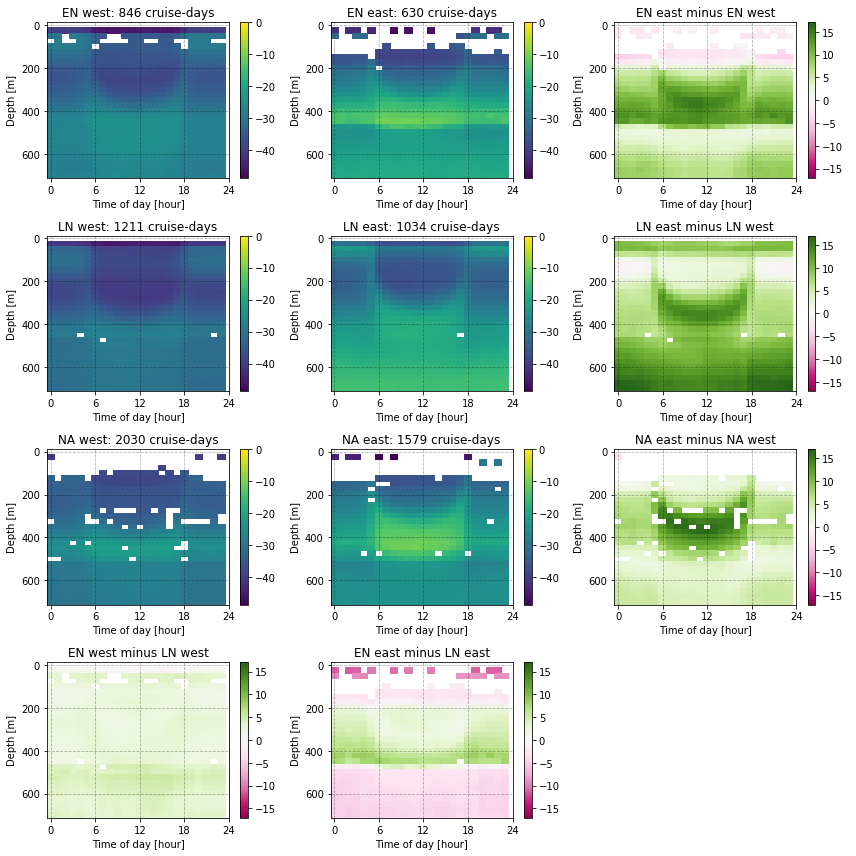

In [63]:
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
gridls = '--'
gridcolor = 'black'
gridalpha = 0.3
xticksnow = np.arange(0,30,6)
divcmapnow = cm.PiYG

isp = 0
arrnow = np.array(Svcd_xr_plt_mean)
#vmaxnow = np.nanmax(arrnow[~np.isinf(arrnow)])
vmaxnow = 0
vminnow = np.nanmin(arrnow[~np.isinf(arrnow)])
for yax in np.arange(0,3):
    for xax in np.arange(0,2):
        Svcd_xr_plt_mean[isp].plot(ax=axes[yax][xax], y='depth', yincrease=False, vmin=vminnow, vmax=vmaxnow)
        axes[yax][xax].set_xlabel('Time of day [hour]')
        axes[yax][xax].set_ylabel('Depth [m]')
        axes[yax][xax].set_title(Svcd_xr_plt_title[isp] + ': ' + str(Svcd_xr_plt[isp].shape[2]) + ' cruise-days')
        axes[yax][xax].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
        axes[yax][xax].set_xticks(xticksnow)
        isp += 1

isp = 0
vminmaxnow = 0
for yax in np.arange(0,3):
    Svdiffnow = Svcd_xr_plt_mean[isp+1]-Svcd_xr_plt_mean[isp]
    vminmaxnow = max(np.nanmax(abs(Svdiffnow.where(~np.isinf(Svdiffnow)))), vminmaxnow)
    isp += 2
isp = 0
for xax in np.arange(0,2):
    Svdiffnow = Svcd_xr_plt_mean[isp]-Svcd_xr_plt_mean[isp+2]
    vminmaxnow = max(np.nanmax(abs(Svdiffnow.where(~np.isinf(Svdiffnow)))), vminmaxnow)
    isp += 1

isp = 0
for yax in np.arange(0,3):
    Svdiffnow = Svcd_xr_plt_mean[isp+1]-Svcd_xr_plt_mean[isp]
    Svdiffnow.plot(ax=axes[yax][xax+1], y='depth', yincrease=False,
                   vmin=-vminmaxnow, vmax=vminmaxnow, cmap=divcmapnow)
    axes[yax][xax+1].set_xlabel('Time of day [hour]')
    axes[yax][xax+1].set_ylabel('Depth [m]')
    axes[yax][xax+1].set_title(Svcd_xr_plt_title[isp+1] + ' minus ' + Svcd_xr_plt_title[isp])
    axes[yax][xax+1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
    axes[yax][xax+1].set_xticks(xticksnow)
    isp += 2

isp = 0
for xax in np.arange(0,2):
    Svdiffnow = Svcd_xr_plt_mean[isp]-Svcd_xr_plt_mean[isp+2]
    Svdiffnow.plot(ax=axes[yax+1][xax], y='depth', yincrease=False,
                   vmin=-vminmaxnow, vmax=vminmaxnow, cmap=divcmapnow)
    axes[yax+1][xax].set_xlabel('Time of day [hour]')
    axes[yax+1][xax].set_ylabel('Depth [m]')
    axes[yax+1][xax].set_title(Svcd_xr_plt_title[isp] + ' minus ' + Svcd_xr_plt_title[isp+2])
    axes[yax+1][xax].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
    axes[yax+1][xax].set_xticks(xticksnow)
    isp += 1
axes[3,2].axis('off')
fig.tight_layout()

In [102]:
enwnow = Svcd_enw_xr.isel(depth=np.arange(0,29))
lnwnow = Svcd_lnw_xr.isel(depth=np.arange(0,29))
enenow = Svcd_ene_xr.isel(depth=np.arange(0,29))
lnenow = Svcd_lne_xr.isel(depth=np.arange(0,29))
Svcd_w_mean = (enwnow.mean(dim='cruise_day')*enwnow.shape[2] + 
               lnwnow.mean(dim='cruise_day')*lnwnow.shape[2]) \
                    /(enwnow.shape[2]+lnwnow.shape[2])
Svcd_e_mean = (enenow.mean(dim='cruise_day')*enenow.shape[2] + 
               lnenow.mean(dim='cruise_day')*lnenow.shape[2]) \
                    /(enenow.shape[2]+lnenow.shape[2])
#Svcd_w_mean = np.nanmean(np.dstack([enwnow, lnwnow]), axis=2)
#Svcd_e_mean = np.nanmean(np.dstack([enenow, lnenow]), axis=2)
Svcd_w_enmmean = enwnow.mean(dim='cruise_day') - Svcd_w_mean
Svcd_w_lnmmean = lnwnow.mean(dim='cruise_day') - Svcd_w_mean
Svcd_e_enmmean = enenow.mean(dim='cruise_day') - Svcd_e_mean
Svcd_e_lnmmean = lnenow.mean(dim='cruise_day') - Svcd_e_mean
Svcd_w_std = np.nanstd(np.dstack([enwnow, lnwnow]), axis=2)
Svcd_e_std = np.nanstd(np.dstack([enenow, lnenow]), axis=2)

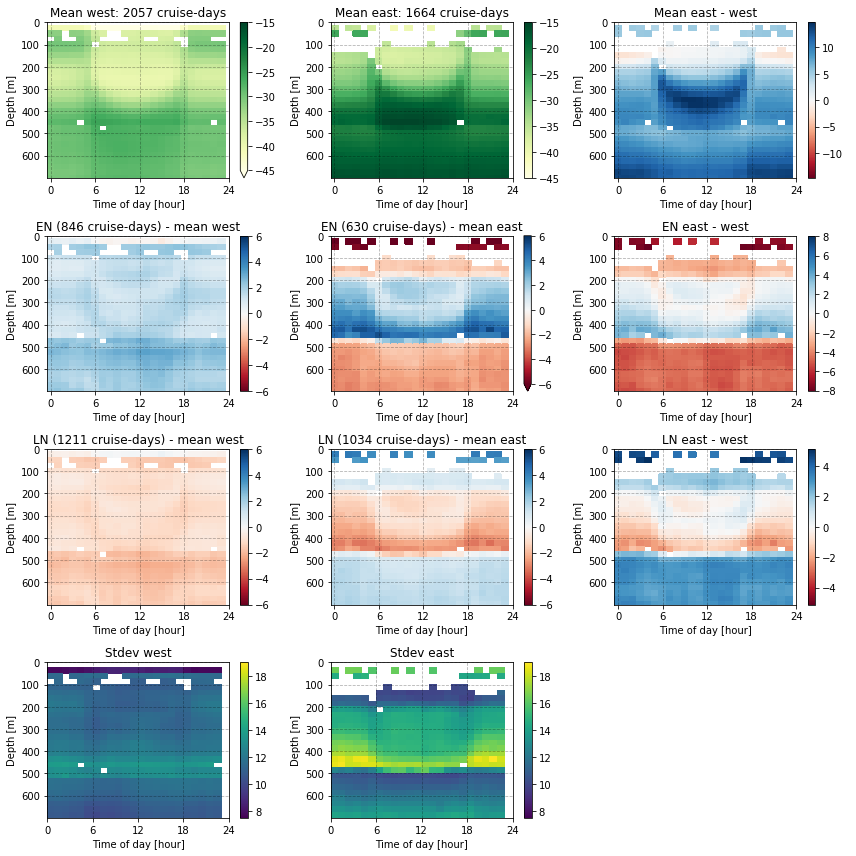

In [121]:
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
gridls = '--'
gridcolor = 'black'
gridalpha = 0.3
xticksnow = np.arange(0,30,6)
yticksnow = np.arange(0,700,100)
divcmapnow = cm.RdBu #cm.PiYG
seqcmapnow = cm.YlGn

vminnow, vmaxnow = -45, -15
Svcd_w_mean.plot(ax=axes[0][0], y='depth', yincrease=False,
                 vmin=vminnow, vmax=vmaxnow, cmap=seqcmapnow)
axes[0][0].set_xlabel('Time of day [hour]')
axes[0][0].set_ylabel('Depth [m]')
axes[0][0].set_title('Mean west: ' + str(enwnow.shape[2]+lnwnow.shape[2]) + ' cruise-days')
axes[0][0].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[0][0].set_xticks(xticksnow)
axes[0][0].set_yticks(yticksnow);
axes[0][0].set_ylim([700,0])

Svcd_e_mean.plot(ax=axes[0][1], y='depth', yincrease=False,
                 vmin=vminnow, vmax=vmaxnow, cmap=seqcmapnow)
axes[0][1].set_xlabel('Time of day [hour]')
axes[0][1].set_ylabel('Depth [m]')
axes[0][1].set_title('Mean east: ' + str(enenow.shape[2]+lnenow.shape[2]) + ' cruise-days')
axes[0][1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[0][1].set_xticks(xticksnow);
axes[0][1].set_yticks(yticksnow);
axes[0][1].set_ylim([700,0])

(Svcd_e_mean-Svcd_w_mean).plot(ax=axes[0][2], y='depth', yincrease=False, cmap=divcmapnow)
axes[0][2].set_xlabel('Time of day [hour]')
axes[0][2].set_ylabel('Depth [m]')
axes[0][2].set_title('Mean east - west')
axes[0][2].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[0][2].set_xticks(xticksnow);
axes[0][2].set_yticks(yticksnow);
axes[0][2].set_ylim([700,0])

vminnow, vmaxnow = -6, 6
Svcd_w_enmmean.plot(ax=axes[1][0], y='depth', yincrease=False,
                    vmin=vminnow, vmax=vmaxnow, cmap=divcmapnow)
axes[1][0].set_xlabel('Time of day [hour]')
axes[1][0].set_ylabel('Depth [m]')
axes[1][0].set_title('EN (' + str(enwnow.shape[2]) + ' cruise-days) - mean west')
axes[1][0].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[1][0].set_xticks(xticksnow);
axes[1][0].set_yticks(yticksnow);
axes[1][0].set_ylim([700,0])

Svcd_e_enmmean.plot(ax=axes[1][1], y='depth', yincrease=False,
                    vmin=vminnow, vmax=vmaxnow, cmap=divcmapnow)
axes[1][1].set_xlabel('Time of day [hour]')
axes[1][1].set_ylabel('Depth [m]')
axes[1][1].set_title('EN (' + str(enenow.shape[2]) + ' cruise-days) - mean east')
axes[1][1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[1][1].set_xticks(xticksnow);
axes[1][1].set_yticks(yticksnow);
axes[1][1].set_ylim([700,0])

(Svcd_e_enmmean-Svcd_w_enmmean).plot(ax=axes[1][2], y='depth', yincrease=False, cmap=divcmapnow)
axes[1][2].set_xlabel('Time of day [hour]')
axes[1][2].set_ylabel('Depth [m]')
axes[1][2].set_title('EN east - west')
axes[1][2].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[1][2].set_xticks(xticksnow);
axes[1][2].set_yticks(yticksnow);
axes[1][2].set_ylim([700,0])

Svcd_w_lnmmean.plot(ax=axes[2][0], y='depth', yincrease=False,
                    vmin=vminnow, vmax=vmaxnow, cmap=divcmapnow)
axes[2][0].set_xlabel('Time of day [hour]')
axes[2][0].set_ylabel('Depth [m]')
axes[2][0].set_title('LN (' + str(lnwnow.shape[2]) + ' cruise-days) - mean west')
axes[2][0].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[2][0].set_xticks(xticksnow);
axes[2][0].set_yticks(yticksnow);
axes[2][0].set_ylim([700,0])

Svcd_e_lnmmean.plot(ax=axes[2][1], y='depth', yincrease=False,
                    vmin=vminnow, vmax=vmaxnow, cmap=divcmapnow)
axes[2][1].set_xlabel('Time of day [hour]')
axes[2][1].set_ylabel('Depth [m]')
axes[2][1].set_title('LN (' + str(lnenow.shape[2]) + ' cruise-days) - mean east')
axes[2][1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[2][1].set_xticks(xticksnow);
axes[2][1].set_yticks(yticksnow);
axes[2][1].set_ylim([700,0])

(Svcd_e_lnmmean-Svcd_w_lnmmean).plot(ax=axes[2][2], y='depth', yincrease=False, cmap=divcmapnow)
axes[2][2].set_xlabel('Time of day [hour]')
axes[2][2].set_ylabel('Depth [m]')
axes[2][2].set_title('LN east - west')
axes[2][2].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[2][2].set_xticks(xticksnow);
axes[2][2].set_yticks(yticksnow);
axes[2][2].set_ylim([700,0])

vminnow, vmaxnow = 7.5, 19
pc = axes[3][0].pcolormesh(np.arange(0,24), std_depths[0:29], Svcd_w_std.transpose(),
                    vmin=vminnow, vmax=vmaxnow)
                    #cmap=seqcmapnow)
plt.colorbar(pc, ax=axes[3][0])
axes[3][0].set_xlabel('Time of day [hour]')
axes[3][0].set_ylabel('Depth [m]')
axes[3][0].set_title('Stdev west')
axes[3][0].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[3][0].set_xticks(xticksnow);
axes[3][0].set_yticks(yticksnow);
axes[3][0].set_ylim([700,0])

pc = axes[3][1].pcolormesh(np.arange(0,24), std_depths[0:29], Svcd_e_std.transpose(),
                    vmin=vminnow, vmax=vmaxnow)
                    #cmap=seqcmapnow)
plt.colorbar(pc, ax=axes[3][1])
axes[3][1].set_xlabel('Time of day [hour]')
axes[3][1].set_ylabel('Depth [m]')
axes[3][1].set_ylim([700,0])
axes[3][1].set_title('Stdev east')
axes[3][1].grid(linestyle=gridls, color=gridcolor, alpha=gridalpha)
axes[3][1].set_xticks(xticksnow);
axes[3][1].set_yticks(yticksnow);
axes[3][1].set_ylim([700,0])

axes[3,2].axis('off')

fig.tight_layout()
fig.savefig(figpath + 'JASADCP_Tropical_Pacific_cruises_Svcd_ENSO_avgs_poster.png',
            bbox_inches='tight', pad_inches = 0, dpi = 200)

# PCA

In [ ]:
# CONTINUE HERE!!!!!
# - old
#Sv_pca0 = Sv.fillna(Sv.min())
#print(np.sum(np.isnan(Sv_pca0.values)))
#Sv_pca0 = Sv_filled.resample(time='1H').mean()
#print(np.sum(np.isnan(Sv_pca0)))
all_days = pd.to_datetime(Sv['time'].values).normalize().unique()
tot_cdays = len(all_days)
daynow = pd.to_datetime(Sv['time'][0].values)
Sv_pca = None
for iday in range(0,tot_cdays):
    daynow = all_days[iday]
    day_strnow = daynow.strftime('%Y-%m-%d') 
    Svhrnow = Sv_pca0.sel(time=day_strnow).groupby('time.hour').mean(dim='time')
    #print(Svhrnow.shape)
    #print(np.sum(np.isnan(Svhrnow.values)))
    #print(np.sum(np.isinf(Svhrnow.values)))
    if Svhrnow.shape[0]==24:
        if Sv_pca is None:
            Sv_pca = Svhrnow.values.ravel()
        else:
            Sv_pca = np.vstack([Sv_pca, Svhrnow.values.ravel()])
print(np.sum(np.isnan(Sv_pca)))
print(np.sum(np.isinf(Sv_pca)))

In [ ]:
x = np.arange(0, array.shape[1])
y = np.arange(0, array.shape[0])
#mask invalid values
array = np.ma.masked_invalid(array)
xx, yy = np.meshgrid(x, y)
#get only the valid values
x1 = xx[~array.mask]
y1 = yy[~array.mask]
newarr = array[~array.mask]
GD1 = interpolate.griddata((x1, y1), newarr.ravel(),
                          (xx, yy),
                             method='cubic')

In [116]:
Svcdnow = Svcd_enw_xr

In [117]:
Sv_pca = None

In [126]:
meannow = Svcdnow.mean(dim='cruise_day')
meanvnow = meannow.values

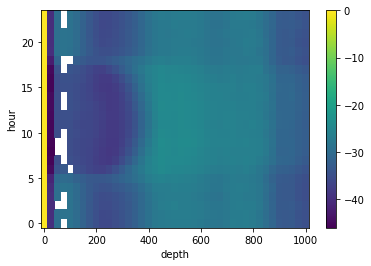

In [130]:
meannow.fillna(0).plot()

In [127]:
print(np.sum(np.isnan(meannow.values)))
print(np.sum(np.isinf(meannow.values)))

24
18


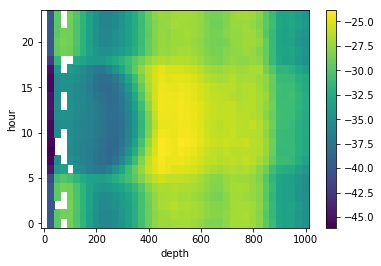

In [128]:
meannow.plot()

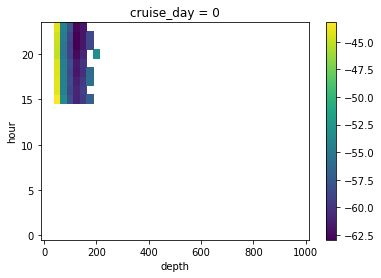

In [118]:
slicenow = Svcdnow[:,:,0]
slicenow.plot()

In [114]:
for icd in np.arange(0,Svcdnow.shape[2]):
    slicenow = Svcdnow[:,:,icd]
    if Sv_pca is None:
        Sv_pca = slicenow.values.ravel()
    else:
        Sv_pca = np.vstack([Sv_pca, Slicenow.values.ravel()])

IndexError: tuple index out of range

In [ ]:
u, s, v = np.linalg.svd(Sv_pca.transpose())

In [ ]:
num_days = Sv_pca.shape[0]
num_depth_cells = Sv_pca0.shape[1]

In [ ]:
for ieof in np.arange(0,3): 
    uf = u[:,ieof].reshape((24,num_depth_cells))
    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(4,2))
    pc = ax.pcolormesh(np.arange(0,24),Sv_depth_arr,uf.transpose())
    ax.set_ylim([Sv_depth_arr.max(),0])
    plt.colorbar(pc, ax=ax)

In [ ]:
from matplotlib.ticker import AutoMinorLocator
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10,2))
for ieof in np.arange(0,3):
    ax.plot(v[:,ieof],label=str(ieof))
    ax.plot([0,num_days],[0,0],'k--')
ax.legend()
ax.xaxis.set_minor_locator(AutoMinorLocator())

# Edge detection + averaging

In [88]:
#std_depths[0:29] goes from 0 to 700
Svcd_xr_plt = [Svcd_enw_xr, Svcd_ene_xr, Svcd_lnw_xr, Svcd_lne_xr, Svcd_naw_xr, Svcd_nae_xr]
Svcd_xr_plt_mean = [Svcd_enw_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_ene_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_lnw_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_lne_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_naw_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day'),
                    Svcd_nae_xr.isel(depth=np.arange(0,29)).mean(dim='cruise_day')]
Svcd_w_mean = Svcd_enw_xr 
Svcd_e_mean = 
Svcd_xr_plt_title = ['EN west', 'EN east', 'LN west', 'LN east', 'NA west', 'NA east']

In [33]:
enwnow = Svcd_enw_xr.isel(depth=np.arange(0,29))
lnwnow = Svcd_lnw_xr.isel(depth=np.arange(0,29))
enenow = Svcd_enw_xr.isel(depth=np.arange(0,29))
lnenow = Svcd_lnw_xr.isel(depth=np.arange(0,29))
Svcd_w_mean = ( enwnow.mean(dim='cruise_day')*enwnow.shape[2] + 
               lnwnow.mean(dim='cruise_day')*lnwnow.shape[2] )/(enwnow.shape[2]+lnwnow.shape[2])
Svcd_e_mean = ( enenow.mean(dim='cruise_day')*enenow.shape[2] + 
               lnenow.mean(dim='cruise_day')*lnenow.shape[2] )/(enenow.shape[2]+lnenow.shape[2])

# Edge detection + PCA

In [ ]:
#conda install -c conda-forge scikit-image

In [ ]:
#https://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html
from scipy import ndimage as ndi
from skimage import feature

In [ ]:
u0 = 10000*u[:,0].reshape((24,num_depth_cells))
u1 = 10000*u[:,0].reshape((24,num_depth_cells))
edges1 = feature.canny(u0, sigma = 1)
edges2 = feature.canny(u0, sigma = 2)
edges3 = feature.canny(u1, sigma = 1)
edges4 = feature.canny(u1, sigma = 2)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(15, 3),
                                    sharex=True, sharey=True)
ax1.pcolormesh(u1)
ax2.pcolormesh(edges1, cmap=plt.cm.gray)
ax3.pcolormesh(edges2, cmap=plt.cm.gray)
ax4.pcolormesh(edges3, cmap=plt.cm.gray)
ax5.pcolormesh(edges4, cmap=plt.cm.gray)
fig.tight_layout()